## Fake News Detection/ Task 02
Fahad Farooq 17L4570     Mahad Farooq    17L4427

In [101]:
#Importing Libraries
import tensorflow as tf
import random
import numpy as np
import pandas as pd
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt
from collections import Counter
from itertools import chain

import gensim
from gensim.models import Word2Vec #word2vec
from gensim.models import KeyedVectors


#To split the data-set into test and train data
from sklearn.model_selection import train_test_split
#To do random permutations of the data-set
from sklearn.utils import shuffle
#For Confusion Matrix 
from sklearn.metrics import confusion_matrix, classification_report
#Transform the words to numbers
from tensorflow.keras.preprocessing.text import Tokenizer
#For Padding Numbers
from tensorflow.keras.preprocessing.sequence import pad_sequences
#Conversion of vectors to matrix
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers

from tensorflow.keras import backend as K 
K.clear_session()
as K

# Cleaning the text from any special characters and non-alphanumeric characters
def clean_text(text):
    #Remove URLs
    text = re.sub(r"http\S+", "", text)
    #Tokenize
    tokenizer = RegexpTokenizer('\w+|\$[\d\.]+|\S+')
    tokens = tokenizer.tokenize(text)
    #Remove non alphanumerica characters
    words = [word for word in tokens if word.isalpha()]    
    return words

# Padding the array length
def pad_array(array, token_len):
    diff_token = token_len - len(array)
    if(diff_token < 0):
        array = array[:token_len] #Truncate
    else:
        #Pad
        array += [0]*diff_token #Pad
        
    return array 
#Loading data-set 
data = pd.read_csv('data.csv')
data = data.fillna(' ')
data.head()K.clear_session()




In [103]:
data['website'] = data.URLs.apply(lambda x: x.split('/')[2])
data.pivot_table(index = 'website', columns = 'Label', values = 'URLs', aggfunc='count').fillna(0).astype(int)

Label,0,1
website,,
abcnews.go.com,0,57
api.content-ad.net,2,0
beforeitsnews.com,1694,0
bleacherreport.com,0,8
clarivate.com,0,3
cnn.it,0,1
dailybuzzlive.com,99,0
edition.cnn.com,0,16
inhealth.cnn.com,0,14


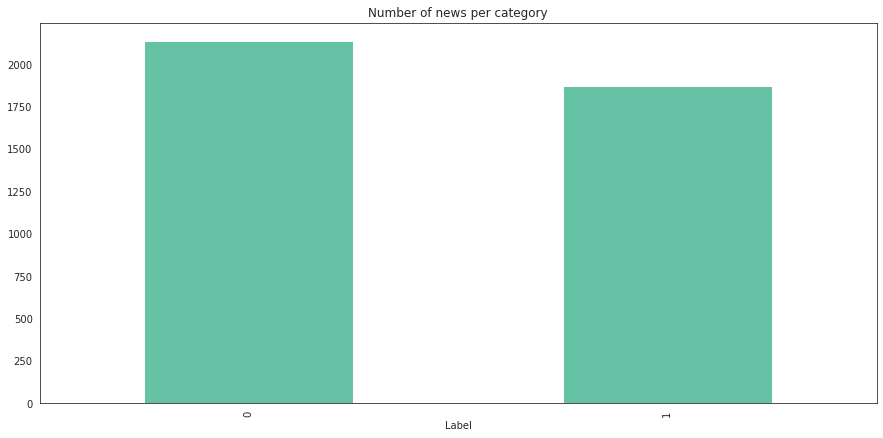

In [105]:

#s imbalance
plt.figure(figsize=(15,7))
data.groupby('Label').count()['Headline'].plot.bar(title="Number of news per category")

We have both the headline and the body and we can use both in our model by concatenating the two.

In [106]:
#Concatenating the two and checking for NaN values
data["Text"] = data["Headline"] + ' ' + data["Body"()]

In [107]:
data = data.drop(columns = ['Headline', 'Body'])

In [108]:
data = data.loc[~data['Text'].isna()]

In [110]:
#Generating frequency and splitting the frequency of words into True and False    d
def print_frequency(words, name):
    counter = Counter(chain.from_iterable(words))
    data_word_distribution = pd.DataFrame(counter.values(), index = counter.keys(), columns = ['Frequency'])
    data_word_distribution.index = data_word_distribution.index.set_names(name)
    data_word_distribution = data_word_distribution.sort_values(by = 'Frequency', ascending = False, axis=0)[:15]
    data_word_distribution = data_word_distribution.pivot_table(columns = name)
    data_word_distribution = data_word_distribution.sort_values(by = 'Frequency', ascending = False, axis=1)
    display(data_word_distr False    
words_fake = [s.split() for s in data.loc[data.Label == 0]['Text']]
words_true = [s.split() for s in data.loc[data.Label == 1]['Text']]
print_frequency(words_fake, 'Fake')
print_frequency(words_true, 'True')

Fake,the,to,and,of,a,in,is,that,for,on,The,with,as,this,was
Frequency,42060,22027,20157,18730,16732,13267,9038,8457,7763,7282,6303,5317,4813,4523,4366


True,the,to,of,a,and,in,on,that,for,is,was,with,The,he,as
Frequency,54608,29145,26449,25009,24464,22863,10691,10385,10315,8790,7526,7279,6998,5926,5838


Embedding needs training, we hold a test set aside to test our model after completion

In [112]:
#Splitting data-set into training and test data-set
text_train, text_test, y_train, y_test = train_test_split(data['Text'], data['Label'], test_size = 0.2, random_state = 42) 


In [113]:


size_embedding = 200 #Dimensionality of the feature vectors
windows = 2 #Maximum distance between the current and predicted word within a sentence
min_count = 1 #Ignores words with total frequency lower than this
maxlen = 1000 #Length decided for the text (adjusted by padding and truncating)

text_train_splited = [article.split() for article in text_train]
w2v_model = gensim.models.Word2Vec(sentences = text_train_splited, 
                                   size = size_embedding, 
                                   window = windows, 
                                   min_count = min_count)

#Tokeis the number
tokenizer = Tokenizer()
tokenizer.fit_on_texts(text_train_splited)
text_train_tok = tokenizer.texts_to_sequences(text_train_splited)
word_index = tokenizer.word_index
vocab_size=len(word_index)
print(vocab_size)


text_train_tok_pad = pad_sequences(text_train_tok, maxlen=maxlen)

95789


In [114]:
# Import tensor representations for words

!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt \
    -O /tmp/glove.6B.100d.txt
embeddings_index = {};
with open('/tmp/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;
print(len(coefs))

embeddings_matrix = np.zeros((vocab_size+1, 100));
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

--2021-01-04 14:44:12--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.31.128, 173.194.214.128, 173.194.215.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.31.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 347116733 (331M) [text/plain]
Saving to: ‘/tmp/glove.6B.100d.txt’

/tmp/glove.6B.100d. 100%[===================>] 331.04M   157MB/s    in 2.1s    

2021-01-04 14:44:14 (157 MB/s) - ‘/tmp/glove.6B.100d.txt’ saved [347116733/347116733]

100


Implementing simple LSTM.

In [115]:

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, 100, weights=[embeddings_matrix], trainable=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(64, 5, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=4),
    tf.keras.layers.LSTM(20, return_sequences=True),
    tf.keras.layers.LSTM(20),
    tf.keras.layers.Dropout(0.2),  
    tf.keras.layers.Dense(512),
    tf.keras.layers.Dropout(0.3),  
    tf.keras.layers.Dense(256),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


In [116]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()


history = model.fit(text_train_tok_pad, y_train, validation_split=0.2, epochs=30, batch_size = 32, verbose =print('Training Complete')lete")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         9579000   
_________________________________________________________________
dropout (Dropout)            (None, None, 100)         0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 64)          32064     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 64)          0         
_________________________________________________________________
lstm (LSTM)                  (None, None, 20)          6800      
_________________________________________________________________
lstm_1 (LSTM)                (None, 20)                3280      
_________________________________________________________________
dropout_1 (Dropout)          (None, 20)                0

              precision    recall  f1-score   support

        Fake       0.99      0.96      0.97       455
    Not Fake       0.95      0.99      0.97       347

    accuracy                           0.97       802
   macro avg       0.97      0.97      0.97       802
weighted avg       0.97      0.97      0.97       802



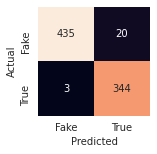

In [118]:
text_train_splited = [article.split() for article in text_test]
text_test_tok = tokenizer.texts_to_sequences(text_train_splited)
text_test_tok_pad = pad_sequences(text_test_tok, maxlen=maxlen)
pred = (model.predict(text_test_tok_pad) > 0.5).astype("int32")

print(classification_report(y_test, pred, target_names = ['Fake','Not Fake'])) 
cm = pd.DataFrame(confusion_matrix(y_test,pred))

fig , ax = plt.subplots(figsize = (2,2))
ax = sns.heatmap(cm, annot = True, xticklabels = ['Fake','True'] , yticklabels = ['Fake','True'], cbar = False, fmt='')
ax.set_xlabel("Predicted"); ax.set_ylabel("Actual"); fig.show()